In [1]:
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli
from scipy.integrate import quad
from scipy.integrate import nquad
from scipy.stats import norm

In [2]:
pi_theta = 1/3240.0
varcov_lambda = np.array(([0.25,0,0,0],[0,0.25,0,0],
                          [0,0,1,0], [0,0,0,1]))

In [3]:
nb_prior = 100

In [4]:
#scale parameters
#epsilon_t

mille = np.linspace(start=100, stop=1000, endpoint=True, num=10)[::-1]
cent = np.linspace(start=10, stop=100, endpoint=False, num=90)[::-1]
dix = np.linspace(start=5, stop=10, endpoint=False, num=10)[::-1]
cinq = np.linspace(start=3, stop=5, endpoint=False, num=40)[::-1]
trois = np.linspace(start=0, stop=3, endpoint=False, num=300)
trois = np.delete(arr=trois, obj=0)
trois = trois[::-1]

scale_param = np.concatenate((mille, cent, dix, cinq, trois))

In [5]:
prior_alpha = np.random.uniform(1.1, 2., size=1000)
prior_beta = np.random.uniform(-1., 1, size=1000)
prior_gamma = np.random.uniform(0., 30., size=1000)
prior_delta = np.random.uniform(-30., 30., size=1000)
prior_gen = np.vstack((prior_alpha,prior_beta,prior_gamma, prior_delta))
prior_gen = np.transpose(prior_gen)

In [6]:
def generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10, epsilon=0.1):
    sample = np.zeros(n)  # Initialize samples array with zeros
    
    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0, 1))
        
        # Handle the case when alpha is close to 1 within the interval (1 - epsilon, 1 + epsilon)
        if abs(alpha - 1) < epsilon:
            # Handle the specific case for alpha near 1
            part1 = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U)) / (np.pi + beta * U)))
            sample[i] = part1
        else:
            # Handle the general case for alpha not near 1
            S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
            B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
    
    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [7]:
def gaussian_ker(u=0, y=0, epsilon=1):
    """gaussian kernel for weights
    
    Parameters
    -------------------
    y : float, or array-like
    the point we have, the output

    u : float, or array-like
    the point from which we want to calculate a weight

    epsilon : int, float
    the scale parameter for which we want to compute the kernel
    ----------
    """

    w = (1/np.sqrt(2*np.pi*(epsilon**2)))*np.exp(-(np.abs((u-y)))**2/(2*(epsilon**2)))
    return w

In [8]:
def zolotarev_transfo(sample, xi=0.25):
    """function to use for the estimation based on the zolotarev transformation

    Parameters
    --------------------------
    Sample : array-like
    Sample to do the transformation on

    xi : int, float
    The constant used in the transformation
    --------------------------
    """
    if xi<=0 or xi>1/2 :
        raise ValueError('Xi must be between 0 and 1/2')
    taille = len(sample)
    Z = []
    for i in range(1,int(taille/3)+1):
        transfo = sample[3*i-3] - xi*sample[3*i-2] - (1 - xi)*sample[3*i-1]
        Z.append(transfo)
    V = []
    U = []
    for i in range(len(Z)):
        V.append(np.log(np.abs(Z[i])))
        U.append(np.sign(sample[i]))
    V = np.array(V)
    U = np.array(U)
    S_U_squared = (np.std(U))**2
    S_V_squared = (np.std(V))**2
    nu_tilde = (6/(np.pi)**2)*S_V_squared - (3/2)*S_U_squared + 1
    etha_hat = np.mean(U)
    tau_hat = np.mean(V)
    nu_hat = 0
    if nu_tilde > ((1+np.abs(etha_hat))**2)/4:
        nu_hat = nu_tilde
    else:
        nu_hat = ((1+np.abs(etha_hat))**2)/4
    delta_hat = np.mean(sample)
    S_2 = np.array((nu_hat, etha_hat, tau_hat, delta_hat))
    return S_2

In [9]:
default = generation(n=1000)

In [10]:
def custom_integrand(u, epsilon_t):
    return np.exp(-u**2 / (2 * epsilon_t**2)) / (np.sqrt(2 * np.pi) * epsilon_t)

In [11]:
def pi_lf(epsilon_t, sample, alpha=1.7, beta=0.9, gamma=10, delta=10, possession=False):
    """function to have the likelihood free density given in the article, the data we create if there is
    no data provided is based on the parameters of 'generation', so for any comparaison between the values of theta,
    those are the parameters to change

    Parameters
    -----------------
    N : int
    number of priors we want to generate
        
    alpha, beta, gamma, delta : int, float
    the parameters with which we want to compute the true data if we don't already have it


    sample : array-like
    the data we observe

    summary_statistic : array-like
    summary statistic used to make tests on the distance between two datasets

    epsilon_t : int, float
    scale parameter, determines 

    Possession : boolean
    by default, set to false, to determine if we want to generate the data or if we already have it

    method : str
    the method with which we would compute the summary statistics
    -------------------
    """
    if possession == False :
        data = generation(n=1000)
    else :
        data = sample
    true_param = zolotarev_transfo(sample=data)
    proposal = generation(n=1000, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
    zolo_proposal = zolotarev_transfo(sample=proposal)
    weight = gaussian_ker(u=np.linalg.norm(true_param-zolo_proposal), epsilon=epsilon_t)
    pi_lf = weight*pi_theta


    normalization_constant, _ = quad(custom_integrand, 0, np.inf, args=(epsilon_t,))


    pi_lf = pi_lf / normalization_constant

    return pi_lf
    
    return pi_lf

weight_gen[i] = pi_lf(epsilon_t=periode_t, theta_i, sample=y)/mutation_density(theta_i, t)

In [12]:
def mutation_creation(theta_t_1):
    """a function to sample a theta_t^(i) as in the paper, according to the distribution of the mutation
    kernel

    Parameters
    -------------------------
    theta_t_1 : array,
    the parameter at step t - 1
    --------------------------
    """
    weighted_random = np.zeros((nb_prior,4))
    for i in range(nb_prior):
        weighted_random[i] = weight_gen[i]*multivariate_normal.rvs(mean=theta_t_1, cov=varcov_lambda, size=1)
    mt_theta = np.sum(a=weighted_random, axis=0)
    return mt_theta

In [13]:
def mutation_density(theta_t, theta_t_1):
    """function that evaluates the pdf of the kernel for a given theta

    Parameters
    ----------------------
    theta_t : 1-D array, 
    the parameter of which we will estimate the probability density at step t

    theta_t_1 : array, 
    the parameter at a step before
    ----------------------
    """
    weighted_estimated = np.zeros(nb_prior)
    for i in range(nb_prior):
        weighted_estimated[i] = weight_gen[i]*multivariate_normal.pdf(theta_t, mean=theta_t_1,
                                                                      cov=varcov_lambda)
    mt_theta = np.sum(a=weighted_estimated, axis=0)
    return mt_theta
    

In [14]:
weight_gen = np.zeros((1000))

In [15]:
def resample(prior_gen=prior_gen, weight_gen=weight_gen, N=1000):
    """Resample N particles (rows) from 'prior_gen' matrix based on weights in 'weight_gen'.
    
    Parameters
    ------------------------
    prior_gen : 1-D or 2-D array,
    matrix of prior particles where each row is a particle

    weight_gen : 1-D or 2-D array 
    vector of weights corresponding to particles
    
    N : int,
    number of particles to resample.
    -------------------------
    """

    total_weight = np.sum(weight_gen)

    if total_weight == 0:
        weights = np.ones_like(weight_gen) / len(weight_gen)
        
    else:

        weights = weight_gen / total_weight

    if np.isnan(weights).any():
        weights[np.isnan(weights)] = 0.0

    indices = np.random.choice(prior_gen.shape[0], size=N, replace=True, p=weights)

    resampled_particles = prior_gen[indices, :]

    return resampled_particles

### Initialization

In [16]:
nb_prior=50

In [17]:
y = generation(n=1000)

In [18]:
weight_gen = np.zeros((nb_prior))

In [19]:
prior_alpha = np.random.uniform(1.1, 2., size=nb_prior)
prior_beta = np.random.uniform(-1, 1, size=nb_prior)
prior_gamma = np.random.uniform(0, 100, size=nb_prior)
prior_delta = np.random.uniform(-100, 100, size=nb_prior)
prior_gen = np.vstack((prior_alpha,prior_beta,prior_gamma, prior_delta))
prior_gen = np.transpose(prior_gen)

In [20]:
prior_gen[10] = np.array((1.7,0.9,10,10))

In [21]:
for i in tqdm(range(nb_prior)):
    weight_gen[i] = pi_lf(epsilon_t=scale_param[0], alpha=prior_alpha[i],
                          beta=prior_beta[i], gamma=prior_gamma[i],
                          delta=prior_delta[i], possession=True, sample=y)/pi_theta
    

100%|██████████| 50/50 [00:00<00:00, 63.74it/s]


In [22]:
prior_gen=resample(prior_gen=prior_gen, weight_gen=weight_gen, N=nb_prior)

In [23]:
prior_t = prior_gen
prior_t_1 = prior_gen

In [24]:
weight_gen = np.ones(nb_prior)*1/nb_prior

In [25]:
for k in tqdm(range(50)):
    c_t = np.quantile(a=weight_gen, q=0.9) #we set the threshold as in the paper, before
    weight_gen = np.ones(nb_prior)*1/nb_prior
    prior_t_1 = prior_t
    for i in tqdm(range(nb_prior)):
        p_i = 0
        decision = 0
        compteur = 0
        while decision != 1 and compteur<100:
            theta_proposal = mutation_creation(prior_t_1[i])
            weight_gen[i] = pi_lf(possession=True, sample=y, epsilon_t=scale_param[k+50],
                                  alpha=theta_proposal[0], beta=theta_proposal[1],
                                  gamma=theta_proposal[2], delta=theta_proposal[2])/mutation_density(theta_t=prior_t[i],
                                                                                                     theta_t_1=prior_t_1[i])

            p_i = np.min((1,weight_gen[i]/c_t))

            if 0 < p_i < 1:
                decision = bernoulli.rvs(p_i, size=1)
                if decision == 1:
                    prior_t[i] = theta_proposal
                    weight_gen[i] = weight_gen[i]/p_i
            compteur += 1
            if compteur == 100:
                weight_gen[i] = 0

        prior_t = resample(prior_gen=prior_t, weight_gen=weight_gen, N=nb_prior)
        

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_336/2385731829.py:18: RuntimeWarning: invalid value encountered in scalar power
  part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)

  6%|▌         | 3/50 [00:06<01:43,  2.20s/it]/tmp/ipykernel_336/2545058262.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  weight_gen[i] = pi_lf(possession=True, sample=y, epsilon_t=scale_param[k+50],
/tmp/ipykernel_336/2385731829.py:15: RuntimeWarning: invalid value encountered in tan
  S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
/tmp/ipykernel_336/2385731829.py:16: RuntimeWarning: invalid value encountered in tan
  B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))
/tmp/ipykernel_336/2385731829.py:18: RuntimeWarning: invalid value encountered in scalar divide
  part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
/tmp/ipykernel_336/85577972.py:15: RuntimeWarning: in

In [26]:
scale_param[0]

1000.0

In [31]:
np.mean(prior_t, axis=0)

array([ 1.92705099, -0.39584545, 42.97326681, 20.49731885])

In [28]:
limit_a = (1.1,2.)
limit_b = (-1.,1.)
limit_c = (0.,100.)
limit_d = (-100., 100.)

In [32]:
observed_data = generation(n=1000)

In [30]:
from scipy import integrate
import numpy as np

def integrate_pi_lf_over_params(alpha_bounds, beta_bounds, gamma_bounds, delta_bounds):
    # Define the integrand function where sample and epsilon_t are fixed
    def integrand(alpha, beta, gamma, delta):
        return pi_lf(epsilon_t, sample, alpha, beta, gamma, delta)
    
    # Perform the integral using nquad over the parameter ranges
    integral, _ = integrate.nquad(integrand, 
                                  [alpha_bounds, beta_bounds, gamma_bounds, delta_bounds])
    
    return integral

# Set the fixed values for sample and epsilon_t
sample = generation(n=1000)  # Example sample data
epsilon_t = 1                 # Example value for epsilon_t

# Define the bounds for integration for alpha, beta, gamma, delta
alpha_bounds = (1.1, 2.)      # Example bounds for alpha
beta_bounds = (-1., 1.)      # Example bounds for beta
gamma_bounds = (0., 100.)    # Example bounds for gamma
delta_bounds = (-100., 100.) # Example bounds for delta

# Call the function to compute the integral of pi_lf over the parameter ranges
integral_result, _ = integrate_pi_lf_over_params(alpha_bounds, beta_bounds, gamma_bounds, delta_bounds)

# Check if the integral result is close to 1
if np.isclose(integral_result, 1.0, atol=1e-4):
    print("pi_lf is a valid probability density function.")
else:
    print("pi_lf does not integrate to 1 over the specified parameter ranges.")


/opt/mamba/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/mamba/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [ ]:
import numpy as np

def generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10, epsilon=0.1):
    sample = np.zeros(n)  # Initialize samples array with zeros
    
    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0, 1))
        
        # Handle the case when alpha is close to 1 within the interval (1 - epsilon, 1 + epsilon)
        if abs(alpha - 1) < epsilon:
            # Handle the specific case for alpha near 1
            part1 = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U)) / (np.pi + beta * U)))
            sample[i] = part1
        else:
            # Handle the general case for alpha not near 1
            S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
            B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
    
    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample


In [33]:
import matplotlib.pyplot as plt

In [34]:
test_alpha = np.linspace(start=0, stop=4, endpoint=True, num=500)

In [35]:
trace=np.zeros((len(test_alpha)))
               
for i in range(len(test_alpha)):
               trace[i] = pi_lf(epsilon_t=1, alpha=test_alpha[i], beta=0.9, gamma=10, delta=10, possession=True,
                                sample=observed_data)


/tmp/ipykernel_336/2385731829.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
/tmp/ipykernel_336/2385731829.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))
/tmp/ipykernel_336/2385731829.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))
/tmp/ipykernel_336/2385731829.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
/tmp/ipykernel_336/2385731829.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
/tmp/ipykernel_336/2385731829.py:18: RuntimeWarning: overflow encountered in scalar power
  part2 = (np.cos(U - alpha * (U 

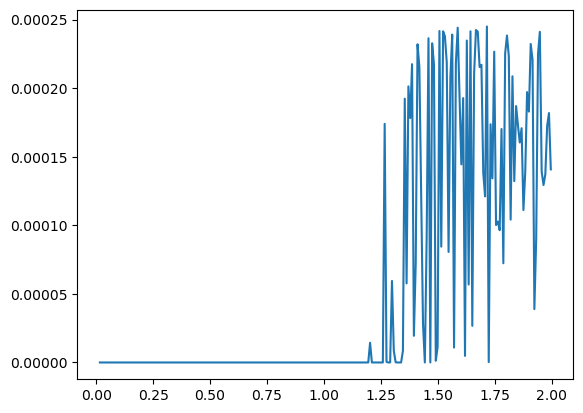

In [36]:
plt.plot(test_alpha,trace, '-')
plt.show()

In [37]:
test_beta = np.linspace(start=-50, stop=50, endpoint=True, num=500)
trace_b=np.zeros((len(test_beta)))
               
for i in range(len(test_beta)):
               trace_b[i] = pi_lf(epsilon_t=1, alpha=1.7, beta=test_beta[i], gamma=10, delta=10, possession=True,
                                sample=observed_data)


/tmp/ipykernel_336/2385731829.py:18: RuntimeWarning: invalid value encountered in scalar power
  part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)


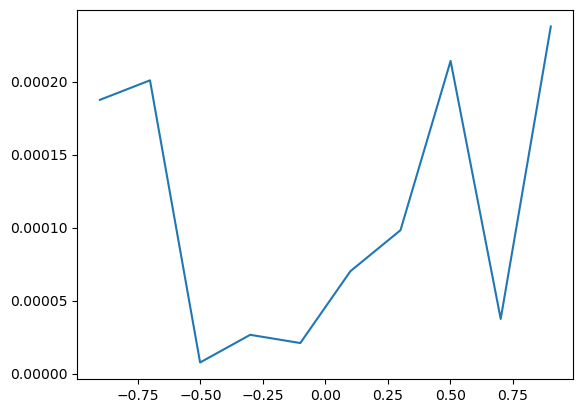

In [38]:
plt.plot(test_beta,trace_b, '-')
plt.show()

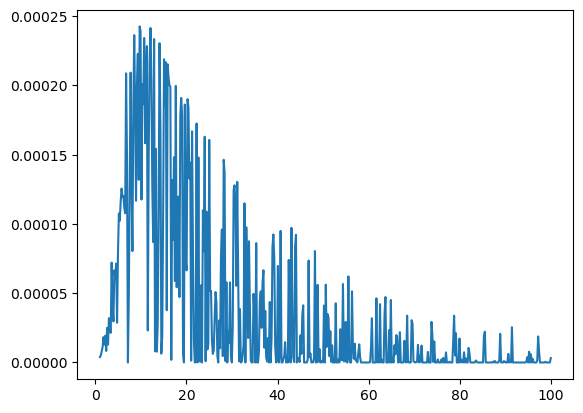

In [39]:
test_gamma = np.linspace(start=1., stop=100, endpoint=True, num=500)
trace_c=np.zeros((len(test_gamma)))
               
for i in range(len(test_gamma)):
               trace_c[i] = pi_lf(epsilon_t=1, alpha=1.7, beta=0.9, gamma=test_gamma[i], delta=10, possession=True,
                                sample=observed_data)
plt.plot(test_gamma,trace_c, '-')
plt.show()

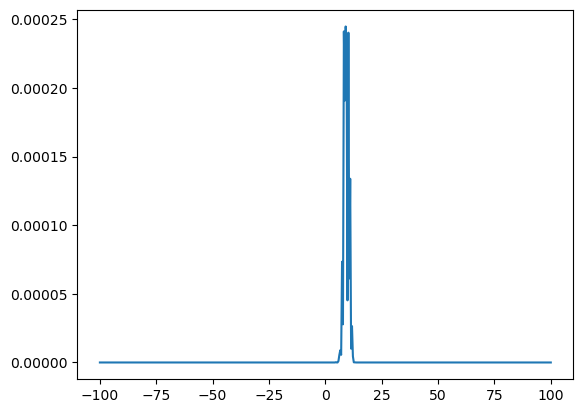

In [40]:
test_delta = np.linspace(start=-100., stop=100, endpoint=True, num=500)
trace_d=np.zeros((len(test_delta)))
               
for i in range(len(test_delta)):
               trace_d[i] = pi_lf(epsilon_t=1, alpha=1.7, beta=0.9, gamma=10, delta=test_delta[i], possession=True,
                                sample=observed_data)
plt.plot(test_delta,trace_d, '-')
plt.show()

In [ ]:
test_norm = np.linspace(start=-10, stop=10, num=500)
to_plot = gaussian_ker(u=test_norm, epsilon=900)


In [ ]:
plt.plot(test_norm, to_plot, '-')
plt.show()

In [ ]:
plt.plot(test_norm, to_plot, '-')
plt.show()

In [ ]:
test_1 = np.array((1,2,3,4))
test_2 = np.array((10,12,14,3))
test_3 = np.array((1,2,2.5,4))

In [ ]:
gaussian_ker(u=np.linalg.norm(test_1-test_1), epsilon=100)